So, I realized I could extract my health data out of my phone over the last three years. so I thought why not tamper with it and might as well learn a few things on the way. the key facts here is that through out this period I have undergone a few abrupt changes. I came here to the US for college, and my diet was completely changed and I started regularly hitting the gym. also I am noticing that ever since moving here I have been having less sleep.

So mainly there are two hypothesis I would like to test
1- that my sleep was reduced after moving in to the US
2- that my activity (active energy burned) has increased after moving to the US

3- I would also like to predict when did I travel. based on energy burned ans sleep, this would be based on the idea that I tend to sleep more back home and I dont go to the gym when I am there. so I will probably need some clustering algorithm for that.

Lets start with the sleep data.

In [ ]:

import seaborn as sns
import xml.etree.ElementTree as ET
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

slp = pd.read_csv('/content/HKCategoryTypeIdentifierSleepAnalysis.csv')




slp.head(5)
act.head(5)

,type,sourcename,sourceversion,device,unit,creationdate,startdate,enddate,value
0,HKQuantityTypeIdentifierActiveEnergyBurned,Ahmed’s iPhone (2),16.1,"<<HKDevice: 0x280969cc0>, name:iPhone, manufac...",Cal,11/1/2022 17:02,10/31/2022 16:40,10/31/2022 16:50,21.095
1,HKQuantityTypeIdentifierActiveEnergyBurned,Ahmed’s iPhone (2),16.1,"<<HKDevice: 0x280969cc0>, name:iPhone, manufac...",Cal,11/1/2022 17:02,10/31/2022 16:50,10/31/2022 17:00,18.070
2,HKQuantityTypeIdentifierActiveEnergyBurned,Ahmed’s iPhone (2),16.1,"<<HKDevice: 0x280969cc0>, name:iPhone, manufac...",Cal,11/1/2022 17:02,10/31/2022 17:00,10/31/2022 17:05,9.513
3,HKQuantityTypeIdentifierActiveEnergyBurned,Ahmed’s iPhone (2),16.1,"<<HKDevice: 0x280969cc0>, name:iPhone, manufac...",Cal,11/1/2022 17:02,10/31/2022 17:05,10/31/2022 17:10,9.637
4,HKQuantityTypeIdentifierActiveEnergyBurned,Ahmed’s iPhone (2),16.1,"<<HKDevice: 0x280969cc0>, name:iPhone, manufac...",Cal,11/1/2022 17:02,10/31/2022 17:16,10/31/2022 17:25,21.786


We notice here that we have a problem. our columns are all stacked into one big column called "sep=;" for some reason. we would like to split them

In [ ]:
slp = slp['sep=;'].str.strip("HKCategoryTypeIdentifierSleepAnalysis;Ahmed’s iPhone(2);15.3.1;6.1;") # we remove useless parts
slp = slp.str.split(' ', n=6, expand=True) # Split the column and create a new DataFrame
slp = slp.drop(0, axis=1) # Drop the first column as it is empty due to split on ''
slp = slp.drop(0, axis=0)
slp = slp.rename(columns={1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'}) # Rename columns
slp = slp.drop('1', axis = 1)
slp['2'] = slp['2'].str.strip("-0400;")
slp['4'] = slp['4'].str.strip("-0400;")
slp['6'] = slp['6'].str.strip("-0400;HKCategoryValueSleepAnalysisInBe")
slp = slp.drop('4', axis = 1)
slp['duration'] = pd.to_datetime(slp['5']) - pd.to_datetime(slp['3'])
slp['duration'] = slp['duration'].dt.total_seconds() / 3600 # lets work with hours easier
slp['duration'] = slp['duration'].astype(float)
slp['duration'] = abs(slp['duration']) # because I think i saw some negative values
slp.rename(columns={'2': 'date', '3': 'start_time', '5': 'end_time', '6': 'Country'}, inplace=True)
slp

<ipython-input-116-01b9350f99c4>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  slp['duration'] = pd.to_datetime(slp['5']) - pd.to_datetime(slp['3'])
<ipython-input-116-01b9350f99c4>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  slp['duration'] = pd.to_datetime(slp['5']) - pd.to_datetime(slp['3'])


,date,start_time,end_time,Country,duration
1,2022-04-2,05:14:36,09:01:14,d;Africa/,3.777222
2,2022-04-25,07:19:09,08:39:08,d;Africa/,1.333056
3,2022-04-25,10:27:35,12:48:38,d;Africa/,2.350833
4,2022-04-26,07:57:42,08:21:43,d;Africa/,0.400278
5,2022-04-26,08:22:28,08:22:40,d;Africa/,0.003333
...,...,...,...,...,...
1643,2024-06-02,09:08:25,09:18:12,d;America/New_York,0.163056
1644,2024-06-03,03:25:41,08:31:49,d;America/New_York,5.102222
1645,2024-06-03,08:34:12,08:39:29,d;America/New_York,0.088056
1646,2024-06,00:50:00,10:00:23,d;America/New_York,9.173056


That should be sufficient data cleaning, we also now have sleep duration column which idk how doesnt already exist

lets try doing some plots

lets see what the average sleep I am getting per country/continent

<Axes: xlabel='Country', ylabel='duration'>

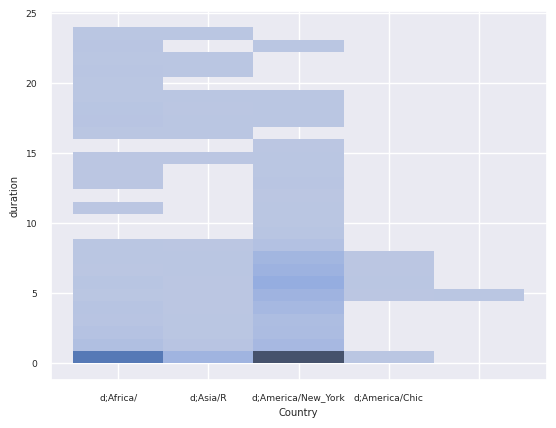

In [ ]:
sns.histplot(data=slp, x = 'Country', y = 'duration')

so thats ..not gonna work.
lets try to first create an average duration for each country, and lets also use different colors for different countries.
we also notice that this is not in fact per country, but per city. so I will have to concatenate the two columns for chicago and ny

In [ ]:
slp['Country'] = slp['Country'].str.replace(r'Africa', 'Cairo', regex=True)
slp['Country'] = slp['Country'].str.replace(r'd;Asia/R', 'Taif', regex=True)
slp['Country'] = slp['Country'].str.replace(r'.*America.*', 'US', regex=True)

print(slp['Country'].unique())
slp = slp[slp['Country'].isin(['d;Cairo/', 'Taif', 'US'])]
mspc = [] # mean sleep per country
countries = []
for country in slp['Country'].unique():
  countries.append(country)
  mspc.append(slp[slp['Country'] == country]['duration'].mean())

['d;Cairo/' 'Taif' 'US' '']


In [ ]:
print(countries)

['d;Cairo/', 'Taif', 'US']


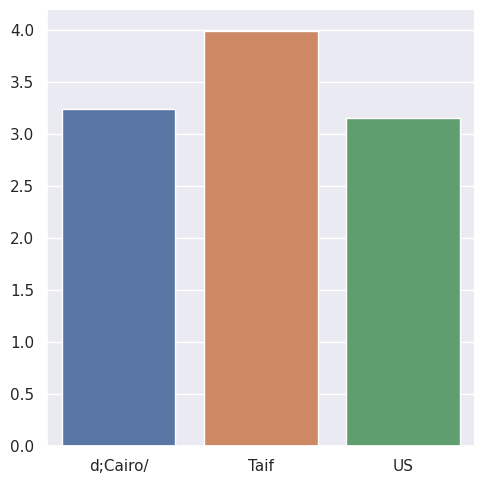

In [ ]:
sns.set_theme()
sns.catplot( kind = 'bar', x = countries, y = mspc, hue = countries) # palette = sns.color_palette('hls', len(mspc)))

Well I clearly dont sleep for an average of four hours a day. and so these metrics are terrible. we do notice however that I sleep slightly more in Egypt than the US. but the difference is not in anyway striking. it also makes sense that my sleep in KSA is the highest since I never have schoolwork when I am there.
I wonder however how does it look over time
lets graph the monthly average from 2022 to 2024 for all three countries.

<ipython-input-120-b938cbebfbfc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slp['date'] = pd.to_datetime(slp['date'], errors = 'coerce')


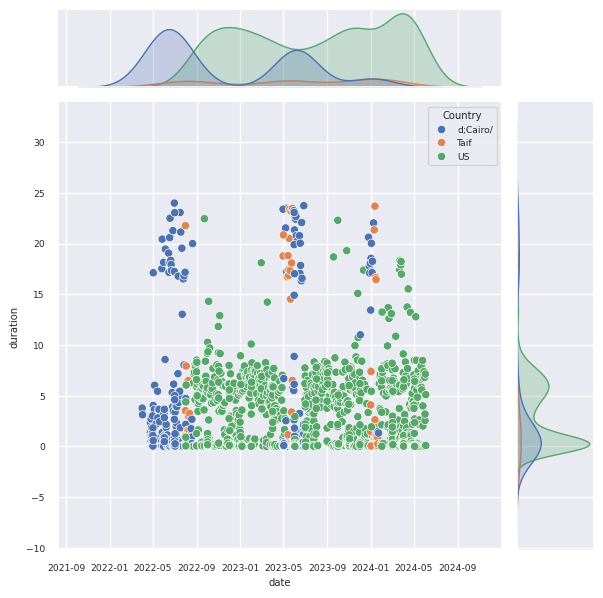

In [ ]:
slp['date'] = pd.to_datetime(slp['date'], errors = 'coerce')
slp = slp.dropna(subset=['date'])
sns.set(font_scale=0.6)
sns.jointplot(data=slp, x="date", y="duration", hue="Country")

Yeahh.. this kinda doesnt mean anything there is no obvious trends. Anyway lets move on to Calories

In [ ]:
act = pd.read_csv('/content/HKQuantityTypeIdentifierActiveEnergyBurned.csv')
act = act.drop('type', axis = 1)
act = act.drop('sourcename', axis = 1)
act = act.drop('device', axis = 1)
act = act.drop('unit', axis = 1)
act = act.drop('sourceversion', axis = 1)
act = act.drop('creationdate', axis = 1)
act = act.drop('enddate', axis = 1)
act.head(5)

,startdate,value
0,10/31/2022 16:40,21.095
1,10/31/2022 16:50,18.070
2,10/31/2022 17:00,9.513
3,10/31/2022 17:05,9.637
4,10/31/2022 17:16,21.786


<Axes: xlabel='startdate', ylabel='value'>

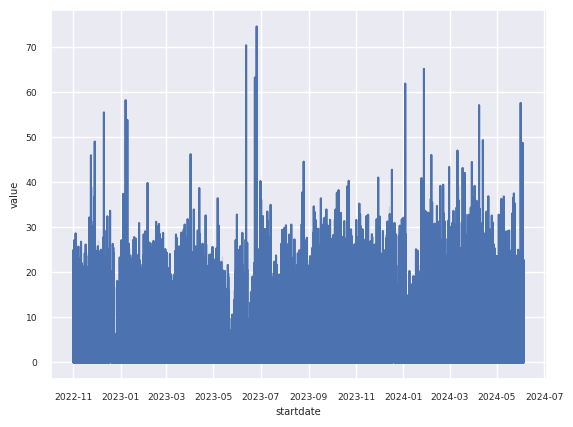

In [ ]:
act.head(5)
act['startdate'] = pd.to_datetime(act['startdate'], errors = 'coerce')
act = act.dropna(subset=['startdate'])
sns.lineplot(data=act, x="startdate", y="value")
#sns.lineplot(data=act, x="startdate", y="value")
#sns.heatmap(act, annot = True, fmt=".0f", cmap="YlGnBu")
#sns.displot(data=act, x="startdate", y="value")

It doesnt look like I can tell a difference between Activity when I was in different countries. but from the first look I notice something else. I can tell when I was most likely travelling from one country to another with it.

In [ ]:
average = act['value'].mean()
threshold = 1.5 * average
print(average)
print(threshold)
plt.axvline(average, color='r', linestyle='--', label=f'Average = {average}')

# Highlighting the threshold line for outliers
plt.axvline(threshold, color='g', linestyle='-', label=f'Threshold = {threshold}')
plt.legend()

# Use plt.show() to display the plot
plt.show()

4.806813644430977
7.210220466646465


AttributeError: 'Axes' object has no attribute 'show'